# Vary Albedo Experiment
This looks at how the gradient of MSE varies when we increase the albedo just at the equator.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
# Use custom matplotlib style for publishing
plt.style.use(os.environ['PWD']+'/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

In [2]:
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.constants import g, R, radius_earth, rot_earth
from isca_tools.utils import area_weighting, annual_time_slice
from isca_tools.utils.ds_slicing import annual_mean
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_scaling_factor_theory
from isca_tools.utils.circulation import get_u_thermal
from isca_tools.utils.constants import c_p
from isca_tools.plot import colored_line

## Get datasets
Average into single year, so get annual mean seasonal cycle.

In [3]:
def get_angular_mom(u, lat, omega=7.2921150e-05, radius=radius_earth):
    cos_lat = np.cos(np.deg2rad(lat))
    return (u+omega*radius*cos_lat)*radius*cos_lat

def get_u_from_angular_mom(ang_mom, lat, omega=7.2921150e-05, radius=radius_earth):
    cos_lat = np.cos(np.deg2rad(lat))
    return ang_mom/radius_earth/cos_lat - omega*radius*cos_lat

In [30]:
# Load dataset - at surface and in free troposphere
use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)
p_surface_approx = np.inf          # Desired approximate pressure of surface (hPa)

# Load dataset

# #Changing Equatorial albedo
# exp_dir = ''
# exp_names = ['rossbypalooza/albedo/depth=1/aqua_0lat_0x',
#              'tau_sweep/aquaplanet/depth=1/k=1', 'rossbypalooza/albedo/depth=1/aqua_0lat_2x', 'rossbypalooza/albedo/depth=1/aqua_0lat_3x']

# #Changing NH albedo
exp_dir = 'rossbypalooza/depth=20/all_nh/lat_10/'
exp_names = ['base', 'albedo_0x']

# only keep variables required to compute relative humidity and MSE
var_keep = ['temp', 'sphum', 't_surf', 'precipitation', 'ucomp', 'vcomp', 'omega', 'height']
lat_use = slice(-90, 90)

n_exp = len(exp_names)
ds_base = []
ds = []
albedo = []
albedo_land = []
tau_sw = []
tau_lw = []
omega = []
time_start = 360*2
time_final = 9999999999999999
summer_months = [7, 8]      # consider just july and august
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for j in range(n_exp):
        namelist = isca_tools.load_namelist(exp_dir + exp_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        try:
            albedo_land += [namelist['mixed_layer_nml']['land_albedo_prefactor'] * albedo[j]]
        except KeyError:
            albedo_land += [albedo[j]]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        try:
            omega += [namelist['constants_nml']['omega']]
        except KeyError:
            omega += [7.2921150e-05]  # default earth value
        
        ds_base += [isca_tools.load_dataset(exp_dir + exp_names[j]).sel(time=slice(time_start, time_final))[var_keep]]
        
        # Compute thermal wind
        var_use_upper_ind = int(np.abs(ds_base[j].pfull - pressure_ft).argmin())
        var_use = annual_mean(ds_base[j].temp.isel(pfull=slice(var_use_upper_ind, -1)).mean(dim='lon')).load()
        var_use = var_use[:, ::-1]      # invert pressure coordinate so 1st is surface
        var_use = var_use.transpose('pfull', 'lat', 'time')     # make time last axis
        var_use[:] = get_u_thermal(var_use, var_use.pfull*100, var_use.lat)     # keep time and lat info by setting each pfull to same array
        
        ds_use = ds_base[j].sel(pfull=[p_surface_approx, pressure_ft], method='nearest')      # only keep the surface and free troposphere values
        ds_use['mse_surf'] = moist_static_energy(ds_use.temp.isel(pfull=0), ds_use.sphum.isel(pfull=0), ds_use.height.isel(pfull=0))
        ds_use['mse_ft_sat'] = moist_static_energy(ds_use.temp.isel(pfull=1), sphum_sat(ds_use.temp.isel(pfull=1), 
                                                                                        ds_use.pfull.isel(pfull=1)*100), 
                                                   ds_use.height.isel(pfull=1))  
        ds_use['mse_lapse'] = ds_use['mse_surf'] - ds_use['mse_ft_sat']
        
        ds_use = annual_mean(ds_use).mean(dim='lon')
        # all pressure levels of var_use are the same
        ds_use['u_thermal'] = var_use.isel(pfull=0).transpose('time', 'lat') + \
                              ds_use.ucomp[:, 0]        # add surface wind as thermal only gives difference between levels
        ds_use['ang_mom'] = get_angular_mom(ds_use.ucomp, ds_use.lat, omega[j])
        ds_use['ang_mom_thermal'] = get_angular_mom(ds_use.u_thermal, ds_use.lat, omega[j])
        ds_use['ang_mom_u0'] = get_angular_mom(0, ds_use.lat, omega[j])

        ds_base[j] = ds_use.sel(lat=lat_use)        # take annual average but keep all months
        ds += [annual_time_slice(ds_base[j], include_months=summer_months).mean(dim='time').load()]     # Take average over the summer months
        # ds_use = annual_mean(ds_use).mean(dim='time')
        # ds += [ds_use]
        pbar.update(1)
pfull = ds_base[0].pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0].pfull.size

  0%|          | 0/2 [00:00<?, ?it/s]/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
 50%|█████     | 1/2 [00:14<00:14, 14.73s/it]/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
100%|██████████| 2/2 [00:27<00:00, 13.94s/it]


In [31]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05
im_sz = 1.5

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

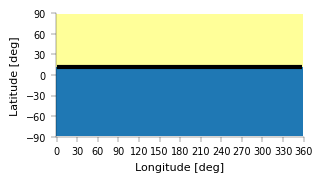

In [32]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir+exp_names[0], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lat_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[0]       # get the longitude coordinates of land
    lat_land_min = float(lat_land.min())
    lat_land_max = float(lat_land.max())
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)
else:
    lat_land_min = None
    lat_land_max = None
    
def show_land(ax, lat_land_min=lat_land_min, lat_land_max=lat_land_max, lat_ax='x', color_land='g', lw_land=4):
    if is_land_data:
        if not isinstance(ax, (list, np.ndarray)):
            raise ValueError(f'ax should be a list or numpy array, but given is {type(ax)}')
        for i in range(len(ax)):
            if lat_ax == 'x':
                var = ax[i].get_ylim()[0]
                xlim = ax[i].get_xlim()
                ax[i].hlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
                ax[i].set_ylim(var, ax[i].get_ylim()[1])
                ax[i].set_xlim(xlim)
            elif lat_ax == 'y':
                var = ax[i].get_xlim()[0]
                ylim = ax[i].get_ylim()
                ax[i].vlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
                ax[i].set_xlim(var, ax[i].get_xlim()[1])
                ax[i].set_ylim(ylim)
            else:
                raise ValueError(f'lat_ax must be either x or y, but {lat_ax} was given.')

## Heat Stress Variables
### Surface Temperature

In [33]:
ind_eq = int(np.abs(ds[0].lat - 0).argmin())
colors_exp = []
for i in range(n_exp):
    if albedo[i] == albedo_land[i]:
        colors_exp += ['k']
    elif albedo_land[i] < albedo[i]:
        colors_exp += [default_colors[3]]
    else:
        colors_exp += [default_colors[0]]

def plot_var(var: str, label: str, unit: str, ind_pressure=None, sharey=False):
    fig, ax = plt.subplots(1, 2, figsize=(2*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=sharey)
    for i in range(n_exp):
        if ind_pressure is None:
            var_use = ds[i][var]
        else:
            var_use = ds[i][var].isel(pfull=ind_pressure)
        ax[0].plot(ds[i].lat, var_use, color=colors_exp[i], label=f"{albedo_land[i]:.2g}")
        ax[1].plot(ds[i].lat, var_use - var_use.isel(lat=ind_eq), color=colors_exp[i])
    show_land(ax)
    ax[0].legend(title='Land Albedo', title_fontsize=7)
    ax[0].set_ylabel(f'{label} [{unit}]')
    ax[1].set_ylabel(f'{label} Relative to Equator [{unit}]')
    ax[1].axhline(0, color='k', lw=ax_linewidth)
    ax[0].axvline(0, color='k', lw=ax_linewidth)
    ax[1].axvline(0, color='k', lw=ax_linewidth)
    ax[0].set_xlim(ds[0].lat.min(), ds[0].lat.max())
    fig.supxlabel('Latitude [deg]', fontsize=8)
    return fig, ax

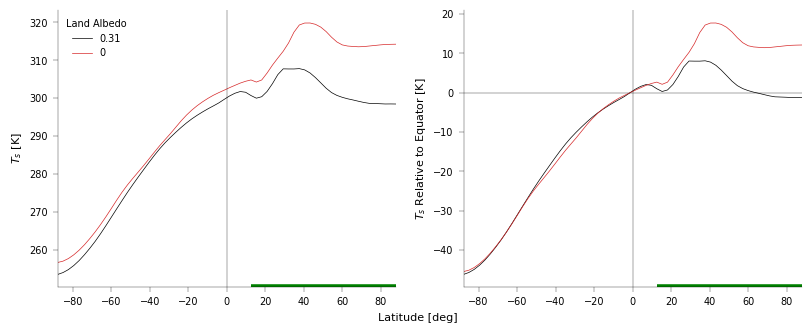

In [34]:
plot_var('t_surf', '$T_s$', 'K');

### Surface MSE

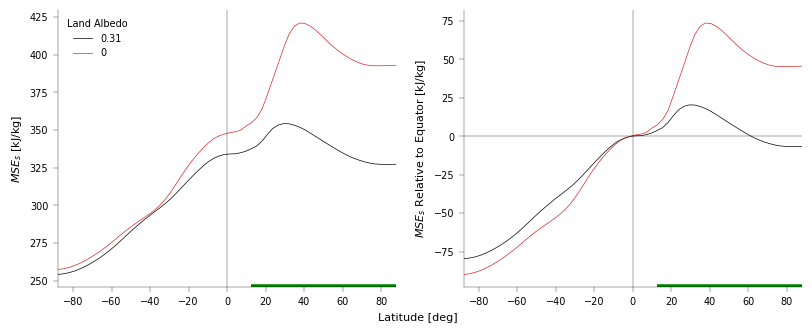

In [35]:
plot_var('mse_surf', '$MSE_s$', 'kJ/kg');

### FT MSE
We expect that in the tropics, WTG makes this have a $\sin^2$ variation with latitude if angular momentum conserved. We see a somehwat similar shape to this.

It is clear the trend with latitude in the deep tropics seems to be the same for all simulations, but reaches further from the equator as the equator is cooled (through increased albedo).

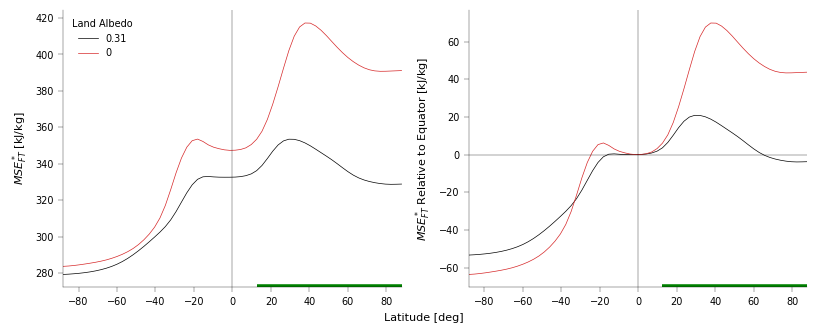

In [36]:
fig, ax = plot_var('mse_ft_sat', '$MSE^*_{FT}$', 'kJ/kg')
# ax[1].plot(ds[0].lat, 100*np.sin(np.deg2rad(ds[0].lat))**2)

### MSE Lapse Rate
In the below plot, we expect in the summer (northern) hemisphere that $MSE_s - MSE^*_{FT}$ be approximately zero to indicate convective stability. We see this is approximately the case, except for the coldest (0.93 equatorial albedo) experiment which has negative value in the equator indicating convection may not be occuring.

This makes sense - as you increase albedo of a region, you make it colder and thus you expect less convection.

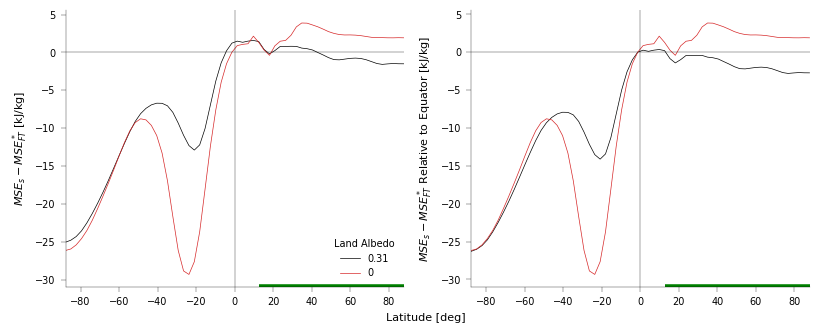

In [37]:
fig, ax = plot_var('mse_lapse', '$MSE_s - MSE^*_{FT}$', 'kJ/kg')
ax[0].axhline(0, color='k', lw=ax_linewidth);

## Circulation Variables
### Zonal Wind - Angular momentum conserving
Below we compare the free tropospheric winds to that expected from conserving equatorial angular momentum. We see that this is better in the winter hemisphere, but breaks down for latitudes greater than $10\degree$ really. Seems to break down at approximately the same point for all simulations.

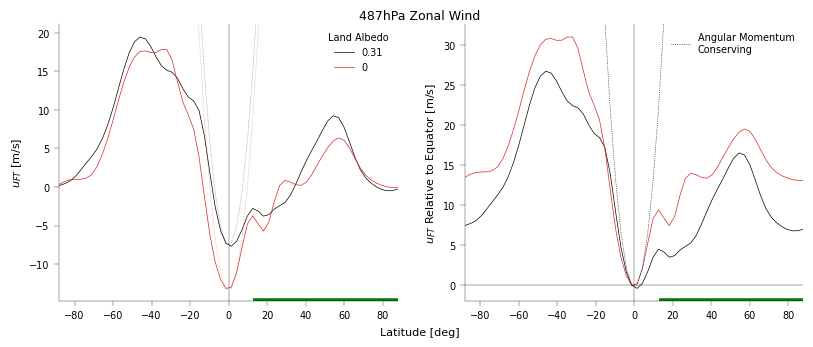

In [38]:
fig, ax = plot_var('ucomp', '$u_{FT}$', 'm/s', ind_pressure=ind_ft)
for i in range(n_exp):
    u_ang_mom = get_u_from_angular_mom(ds[i].ang_mom.isel(lat=ind_eq, pfull=ind_ft), ds[i].lat)
    ax[0].plot(ds[0].lat, u_ang_mom, color=colors_exp[i], linestyle=':', alpha=0.5)
    if albedo[i]==albedo_land[i]:
        ax[1].plot(ds[i].lat, u_ang_mom - u_ang_mom.isel(lat=ind_eq), linestyle=':', color='k', label='Angular Momentum\nConserving')
ax[1].legend()
fig.suptitle(f'{pressure_ft_actual/100:.0f}hPa Zonal Wind', fontsize=9, y=0.92);

### Zonal Wind - Thermal Wind
Below we see that the surface and FT winds are comparable in magnitude. Given that thermal wind only gives difference between the two 
levels, we must account for surface wind in the calculation. 

After doing this, thermal wind seems pretty good at subtropics and larger latitudes.

Text(0.5, 0.01, 'Latitude [deg]')

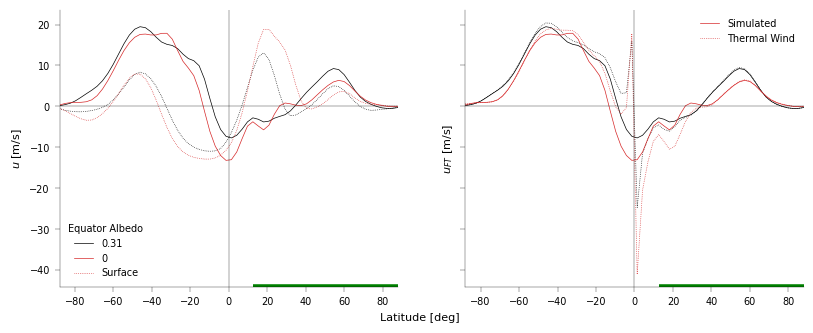

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(2*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
for i in range(n_exp):
    ax[0].plot(ds[i].lat, ds[i].ucomp.isel(pfull=ind_ft), color=colors_exp[i], label=f"{albedo_land[i]:.2g}")
    ax[0].plot(ds[i].lat, ds[i].ucomp.isel(pfull=ind_surf), color=colors_exp[i], linestyle=':', label='Surface' if i==n_exp-1 else None)
    ax[1].plot(ds[i].lat, ds[i].ucomp.isel(pfull=ind_ft), color=colors_exp[i],
               label='Simulated' if i==1 else None)
    ax[1].plot(ds[i].lat, ds[i].u_thermal, color=colors_exp[i], linestyle=':', label='Thermal Wind' if i==1 else None)
show_land(ax)
ax[0].legend(title='Equator Albedo', title_fontsize=7)
ax[1].legend()
ax[0].set_ylabel(f'$u$ [m/s]')
ax[1].set_ylabel('$u_{FT}$ [m/s]')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].axvline(0, color='k', lw=ax_linewidth)
ax[1].axvline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(ds[0].lat.min(), ds[0].lat.max())
fig.supxlabel('Latitude [deg]', fontsize=8)

### Overturning circulation - meridional and zonal winds
The zonal and meridional winds are indicative of a single overturning cell (northward at the surface, southward at the FT throughout tropics)
 for all but the coldest simulation.
 
For the coldest simulation, the lack of convection at the equator seems to cause a dip in the meridional wind magnitude.

Text(0.5, 0, 'Latitude [deg]')

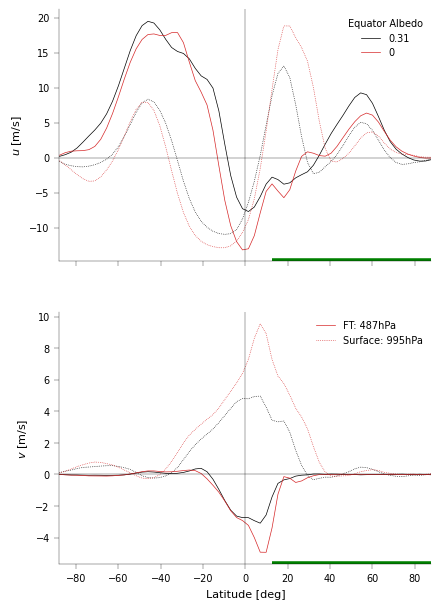

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(im_sz*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(ds[i].lat, ds[i].ucomp.isel(pfull=ind_ft), color=colors_exp[i], label=f"{albedo_land[i]:.2g}")
    ax[0].plot(ds[i].lat, ds[i].ucomp.isel(pfull=ind_surf), color=colors_exp[i], linestyle=':')
    ax[1].plot(ds[i].lat, ds[i].vcomp.isel(pfull=ind_ft), color=colors_exp[i], label=f'FT: {pressure_ft_actual/100:.0f}hPa' if i==1 else None)
    ax[1].plot(ds[i].lat, ds[i].vcomp.isel(pfull=ind_surf), color=colors_exp[i], linestyle=':', 
               label=f'Surface: {p_surface/100:.0f}hPa' if i==1 else None)
show_land(ax)
ax[0].legend(title='Equator Albedo', title_fontsize=7)
ax[1].legend()
ax[0].set_ylabel(f'$u$ [m/s]')
ax[1].set_ylabel('$v$ [m/s]')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].axvline(0, color='k', lw=ax_linewidth)
ax[1].axvline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(ds[0].lat.min(), ds[0].lat.max())
ax[1].set_xlabel('Latitude [deg]')

### Justify Summer Months
Below, I indicate wth the horizontal lines the months selected as typical of summer

In [ ]:
ds_base = [ds_base[i].load() for i in tqdm(range(n_exp))]

100%|██████████| 2/2 [00:16<00:00,  8.08s/it]


Text(0, 0.5, '')

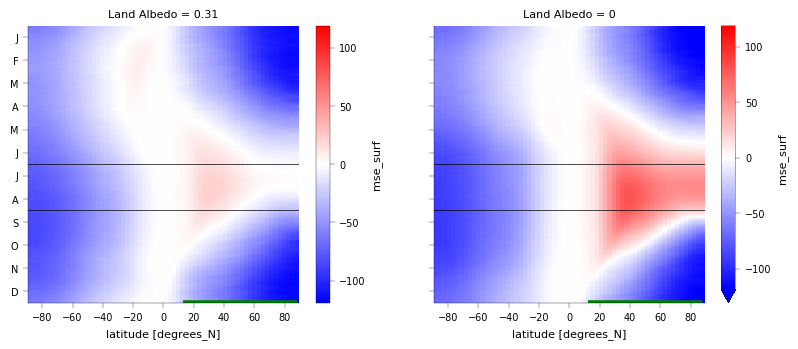

In [41]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

var_plot = 'mse_surf'
# var_plot = 'mse_ft_sat'
var_lim = float(np.abs(ds_base[0][var_plot]-ds_base[0][var_plot].isel(lat=ind_eq)).max())
fig, ax = plt.subplots(1, n_exp, figsize=(im_sz*n_exp*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
for i in tqdm(range(n_exp)):
    (ds_base[i][var_plot]-ds_base[i][var_plot].isel(lat=ind_eq)).plot(ax=ax[i], vmin=-var_lim, vmax=var_lim, cmap='bwr')
    ax[i].axhline(6*30, color='k')
    ax[i].axhline(8*30, color='k')
    ax[i].set_title(f"Land Albedo = {albedo_land[i]:.2g}")
ax[0].set_yticks(*month_ticks)
ax[0].invert_yaxis()
show_land(ax)
ax[0].set_ylabel(None)
ax[1].set_ylabel(None)

100%|██████████| 4/4 [00:00<00:00, 300.19it/s]


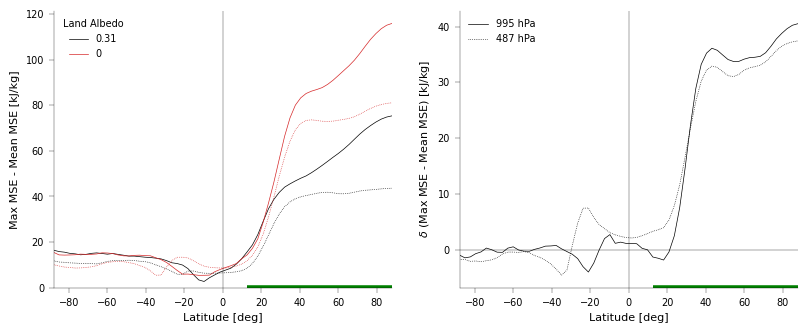

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
with tqdm(total=n_exp*2, position=0, leave=True) as pbar:
    for j, key in enumerate(['mse_surf', 'mse_ft_sat']):
        ax[1].plot(ds[0].lat, (ds_base[1][key].max(dim='time')-ds_base[1][key].mean(dim='time')) -
                   (ds_base[0][key].max(dim='time')-ds_base[0][key].mean(dim='time')), color='k', linestyle=':' if j==1 else '-',
                   label=f"{[p_surface, pressure_ft_actual][j]/100:.0f} hPa")
        for i in range(n_exp):
            ax[0].plot(ds[0].lat, ds_base[i][key].max(dim='time')-ds_base[i][key].mean(dim='time'), color=colors_exp[i],
                    linestyle=':' if j==1 else '-', label=f"{albedo_land[i]:.2g}" if j==0 else None)
            pbar.update(1)
ax[0].legend(title='Land Albedo', title_fontsize=7)
ax[1].legend()
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].axvline(0, color='k', lw=ax_linewidth)
ax[1].axvline(0, color='k', lw=ax_linewidth)
ax[0].set_ylim(0, ax[0].get_ylim()[1])
ax[0].set_xlim(ds[0].lat.min(), ds[0].lat.max())
ax[0].set_ylabel('Max MSE - Mean MSE [kJ/kg]')
ax[1].set_ylabel('$\delta$ (Max MSE - Mean MSE) [kJ/kg]')
ax[0].set_xlabel('Latitude [deg]')
ax[1].set_xlabel('Latitude [deg]')
show_land(ax);

100%|██████████| 4/4 [00:00<00:00, 617.88it/s]


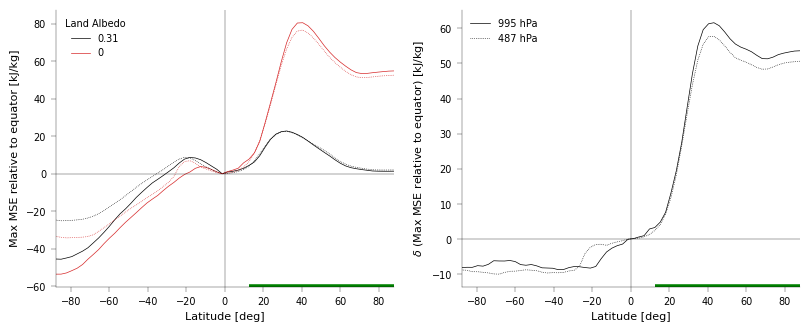

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
with tqdm(total=n_exp*2, position=0, leave=True) as pbar:
    for j, key in enumerate(['mse_surf', 'mse_ft_sat']):
        ax[1].plot(ds[0].lat, (ds_base[1][key]-ds_base[1][key].isel(lat=ind_eq)).max(dim='time')-
                   (ds_base[0][key]-ds_base[0][key].isel(lat=ind_eq)).max(dim='time'), color='k', linestyle=':' if j==1 else '-',
                   label=f"{[p_surface, pressure_ft_actual][j]/100:.0f} hPa")
        for i in range(n_exp):
            ax[0].plot(ds[0].lat, (ds_base[i][key]-ds_base[i][key].isel(lat=ind_eq)).max(dim='time'), color=colors_exp[i],
                    linestyle=':' if j==1 else '-', label=f"{albedo_land[i]:.2g}" if j==0 else None)
            pbar.update(1)
ax[0].legend(title='Land Albedo', title_fontsize=7)
ax[1].legend()
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].axvline(0, color='k', lw=ax_linewidth)
ax[1].axvline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(ds[0].lat.min(), ds[0].lat.max())
ax[0].set_ylabel('Max MSE relative to equator [kJ/kg]')
ax[1].set_ylabel('$\delta$ (Max MSE relative to equator) [kJ/kg]')
ax[0].set_xlabel('Latitude [deg]')
ax[1].set_xlabel('Latitude [deg]')
show_land(ax);

100%|██████████| 4/4 [00:00<00:00, 732.47it/s]


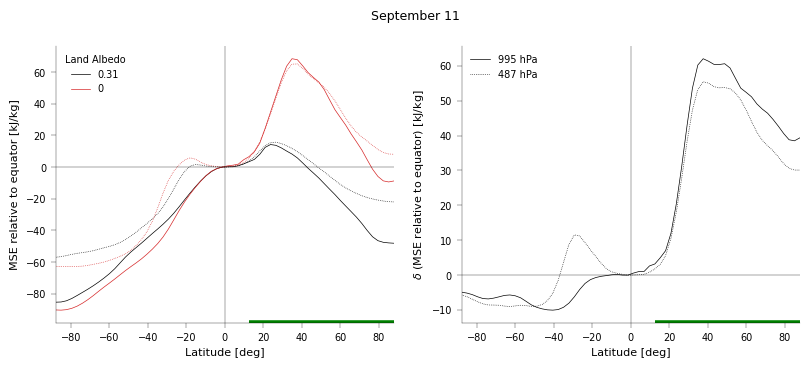

In [66]:
plot_day_ind = 5*30+20      # june 21
plot_day_ind = 8*30+10      # september 11
month_names = ['January','February','March','April','May','June','July','August','September','October','November','December']

fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
with tqdm(total=n_exp*2, position=0, leave=True) as pbar:
    for j, key in enumerate(['mse_surf', 'mse_ft_sat']):
        ax[1].plot(ds[0].lat, (ds_base[1][key]-ds_base[1][key].isel(lat=ind_eq)).isel(time=plot_day_ind)-
                   (ds_base[0][key]-ds_base[0][key].isel(lat=ind_eq)).isel(time=plot_day_ind), color='k', linestyle=':' if j==1 else '-',
                   label=f"{[p_surface, pressure_ft_actual][j]/100:.0f} hPa")
        for i in range(n_exp):
            ax[0].plot(ds[0].lat, (ds_base[i][key]-ds_base[i][key].isel(lat=ind_eq)).isel(time=plot_day_ind), color=colors_exp[i],
                    linestyle=':' if j==1 else '-', label=f"{albedo_land[i]:.2g}" if j==0 else None)
            pbar.update(1)
ax[0].legend(title='Land Albedo', title_fontsize=7)
ax[1].legend()
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].axvline(0, color='k', lw=ax_linewidth)
ax[1].axvline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(ds[0].lat.min(), ds[0].lat.max())
ax[0].set_ylabel('MSE relative to equator [kJ/kg]')
ax[1].set_ylabel('$\delta$ (MSE relative to equator) [kJ/kg]')
ax[0].set_xlabel('Latitude [deg]')
ax[1].set_xlabel('Latitude [deg]')
show_land(ax)
fig.suptitle(f'{month_names[int(np.floor(plot_day_ind/30))]} {plot_day_ind%30+1}', fontsize=9);